In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [2]:
import numpy as np

In [3]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import LeakyReLU, ReLU, ELU
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay, InverseTimeDecay
from tensorflow.keras.layers import BatchNormalization

In [4]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [5]:
from tensorflow.keras.layers import Conv2D

In [6]:
from tensorflow.keras.layers import Flatten

In [7]:
from tqdm.keras import TqdmCallback

Using TensorFlow backend.


In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [9]:
# from scrinet.fits import nn

In [10]:
from scrinet.fits import scale

In [11]:
Xy = np.loadtxt("./data_to_fit.txt")
# sort by X
X_raw, y_raw = Xy[np.argsort(Xy[:, 0])].T

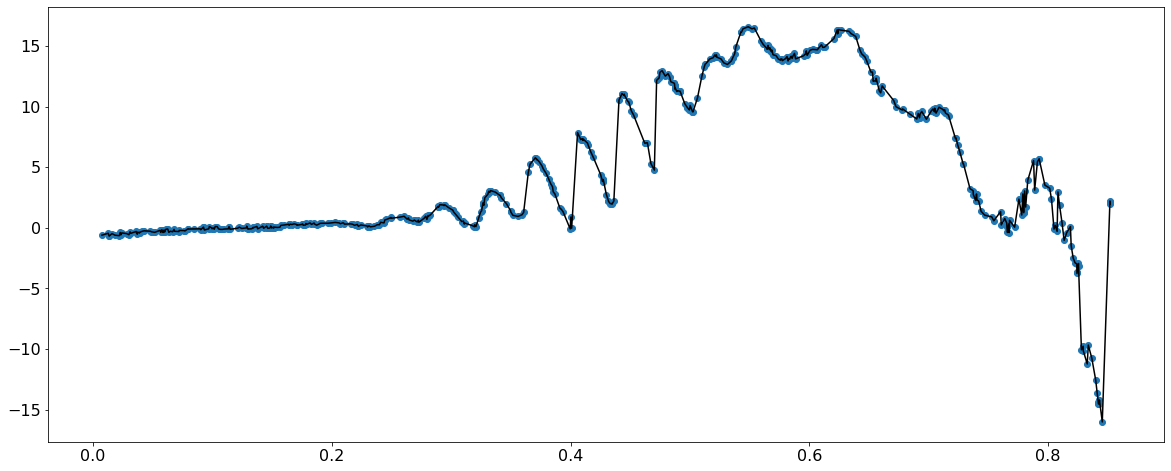

In [12]:
plt.figure(figsize=(20,8))
plt.scatter(X_raw,y_raw)
plt.plot(X_raw, y_raw, c='k')

In [13]:
# lets interpolat and resample

In [14]:
def resample_data(X, y, xmin=None, xmax=None, npts=1000, k=1):
    
    if xmin is None:
        xmin = X[0]
    if xmax is None:
        xmax = X[-1]
    mask = (X>=xmin) & (X<=xmax)
    
    iy = IUS(X[mask], y[mask], k=k)
    
    Xnew = np.linspace(xmin, xmax, npts)
    
    return Xnew, iy(Xnew)

In [47]:
# X, y = resample_data(X_raw, y_raw, xmin=0.4, xmax=0.45, npts=100, k=1)
X, y = resample_data(X_raw, y_raw)
# X, y = resample_data(X_raw, y_raw, npts=10000)
# X, y = X_raw, y_raw

In [48]:
X.shape

(10000,)

In [49]:
y.shape

(10000,)

In [50]:
# mask = (X > 0.3) & (X < 0.4)
# # mask = None
# if mask is not None:
#     X = X[mask]
#     y = y[mask]

In [51]:
X = X.reshape(-1, 1)
y = y.reshape(-1, 1)

In [52]:
scaleX=True
scaleY=True
if scaleX:
    X = X.copy()
    X_scalers = scale.make_scalers(X)
    X = scale.apply_scaler(X, X_scalers)
if scaleY:
    y = y.copy()
    Y_scalers = scale.make_scalers(y)
    y = scale.apply_scaler(y, Y_scalers)

In [53]:
X.shape

(10000, 1)

In [54]:
y.shape

(10000, 1)

In [58]:
# np.savetxt("scaled_data_to_fit.txt", list(zip(X[:,0], y[:,0])))
# np.loadtxt("scaled_data_to_fit.txt")

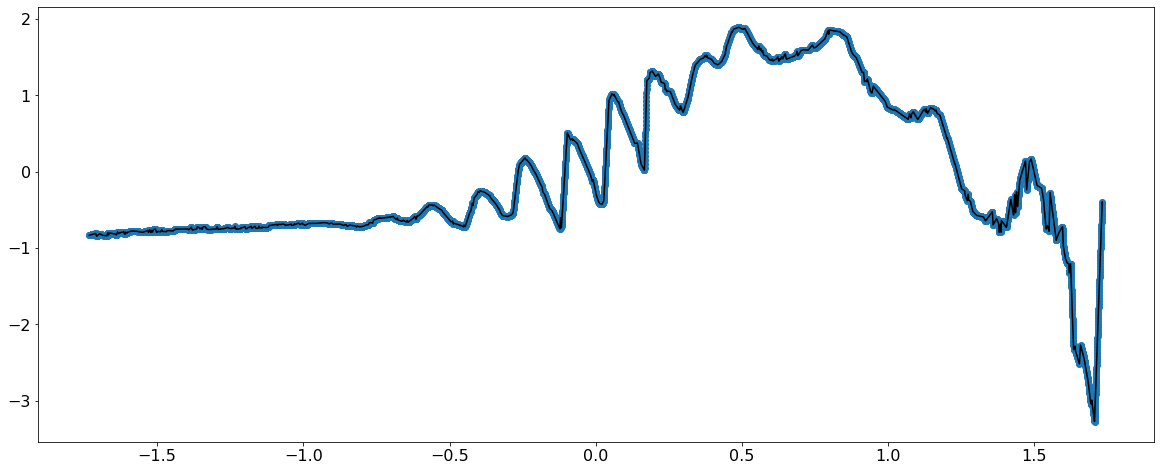

In [21]:
plt.figure(figsize=(20,8))
plt.scatter(X,y)
plt.plot(X, y, c='k')

In [22]:
X.shape

(1000, 1)

In [23]:
input_dim = X.shape[1]
noutput = y.shape[1]

In [40]:
epochs=5000
# input_units=2
# units=[4, 8, 16]
input_units=128
units=[128,128,128]
# input_units=256
# units=[256, 256, 256]
# units=[100,100,100,100,100,100,100,100,100,100,100,100,100,100,100]
# units=[128,128,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,256,128,64]

# input_units = 2
# total_units = 6
# units = []
# for i in range(5):
#     units.append(2**(i+2))
# for i in range(5, total_units):
#     units.append(256)

# units=[128,128]
# activation='relu'
activation=LeakyReLU(alpha=0.3)

# activation='tanh'
# kernel_initializer = 'he_uniform'
kernel_initializer = 'glorot_uniform'

batch_size=40

learning_rate=1e-3

# STEPS_PER_EPOCH=1
# learning_rate = InverseTimeDecay(
#     0.001,
#     decay_steps=STEPS_PER_EPOCH*100,
#     decay_rate=0.8,
#     staircase=False)

# This function keeps the learning rate at 0.001 for the first ten epochs
# and decreases it exponentially after that.
# def scheduler(epoch, rate=1e-3, t0=400, initial=1e-3, tfinal=4000, final=1e-5):
#     if epoch < t0:
#         return initial
#     if epoch >= tfinal:
#         return final
#     else:
#         return initial * tensorflow.math.exp(rate * (t0 - epoch))


# def scheduler(epoch):
    
#     if epoch > 8000:
#         return 1e-5
#     if epoch > 5000:
#         return 1e-4
#     if epoch > 1000:
#         return 1e-3/2
#     else:
#         return 1e-3

def scheduler(epoch):
    
    if epoch > 4000:
        return 1e-5
    elif epoch > 2000:
        return 1e-4
    elif epoch > 1000:
        return 1e-3/2
    else:
        return 1e-3


scheduler_callback = tensorflow.keras.callbacks.LearningRateScheduler(scheduler)
# scheduler_callback = None

In [41]:
units

[128, 128, 128]

In [42]:
# x_epoch = np.array(range(epochs))

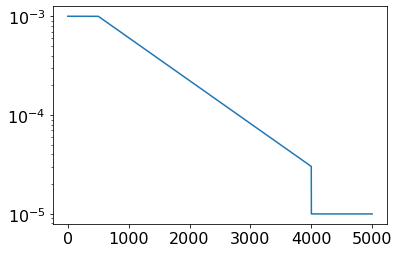

In [27]:
# plt.figure()
# plt.plot(x_epoch, [scheduler(xx, rate=1e-3, t0=500, initial=1e-3) for xx in x_epoch])
# plt.yscale('log')

In [43]:
input_dim

1

In [44]:
X.shape

(1000, 1)

In [45]:
y.shape

(1000, 1)

In [46]:
model = Sequential()
model.add(
    Dense(input_units, activation=activation, input_dim=input_dim, kernel_initializer=kernel_initializer)
)
for i in range(len(units)):
    model.add(
        Dense(units=units[i], activation=activation, kernel_initializer=kernel_initializer, use_bias=True)
    )
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization())
model.add(Dense(noutput, activation='linear'))

optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss = 'mean_squared_error', metrics=['mse','mae'])
# model.compile(optimizer=optimizer, loss = 'mae', metrics=['mse','mae'])


callbacks=[TqdmCallback(verbose=1)]
if scheduler_callback is not None:
    callbacks.append(scheduler_callback)

history = model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=callbacks)

In [47]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               256       
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 49,921
Trainable params: 49,921
Non-trainable params: 0
_________________________________________________________________


In [48]:
history.history.keys()

dict_keys(['loss', 'mse', 'mae', 'lr'])

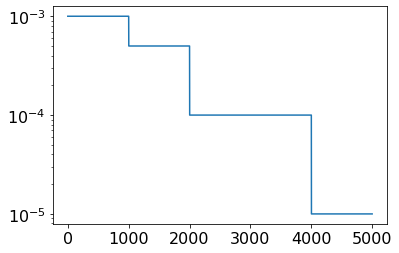

In [49]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

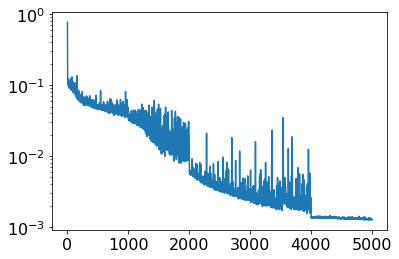

In [50]:
plt.figure()
plt.plot(history.history['loss'])
# plt.plot(history.history['mae'])
# plt.plot(x_epoch, [scheduler(xx, rate=3e-3, t0=100, initial=1e-3) for xx in x_epoch])
plt.yscale('log')

In [51]:
yhat = model.predict(X)

x_extrap = np.linspace(X[0], X[-1], 1000).reshape(-1,1)
y_extrap = model.predict(x_extrap)

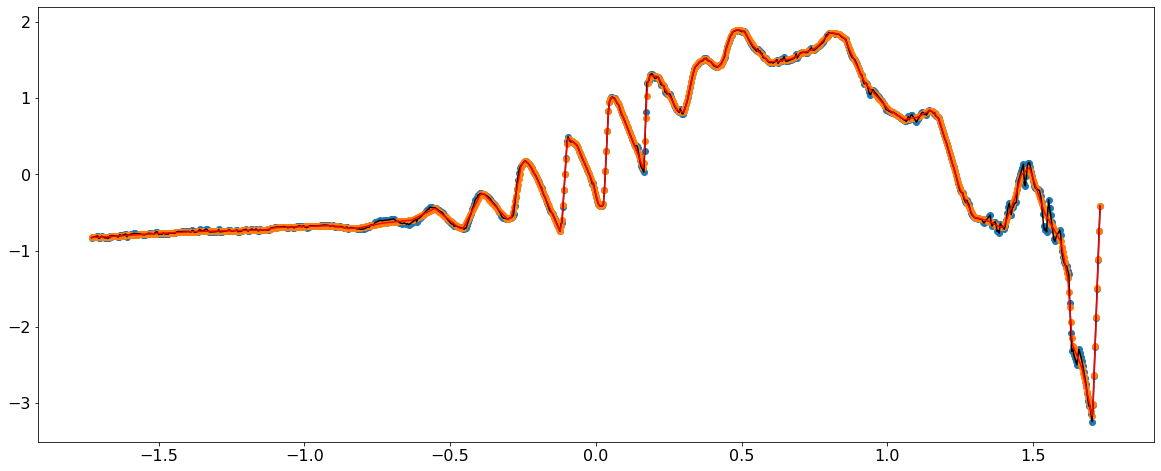

In [52]:
plt.figure(figsize=(20,8))
plt.scatter(X, y)
plt.plot(X, y, c='k')

plt.scatter(X, yhat)

plt.plot(x_extrap, y_extrap, c='r')

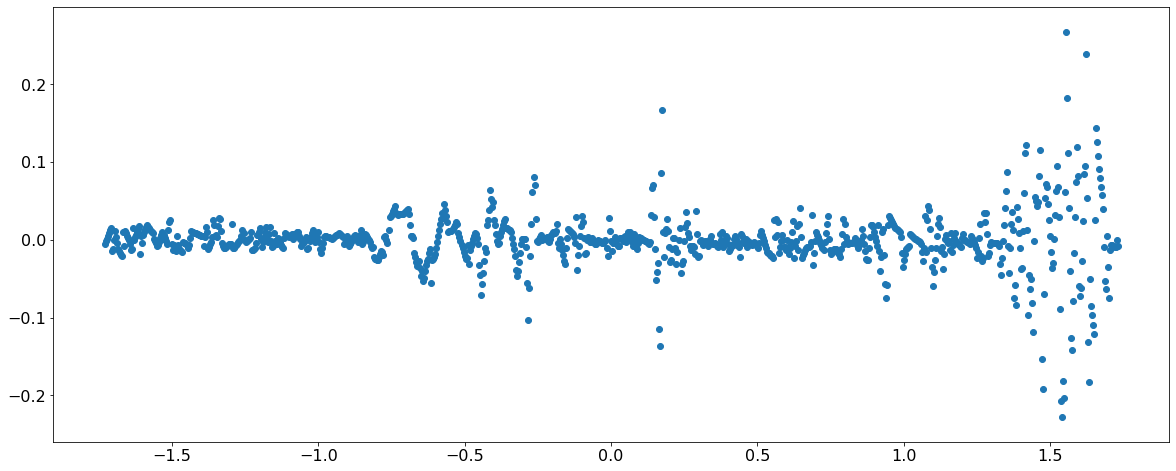

In [53]:
plt.figure(figsize=(20,8))
plt.scatter(X, y-yhat)

(1e-05, 1.1220184543019633)

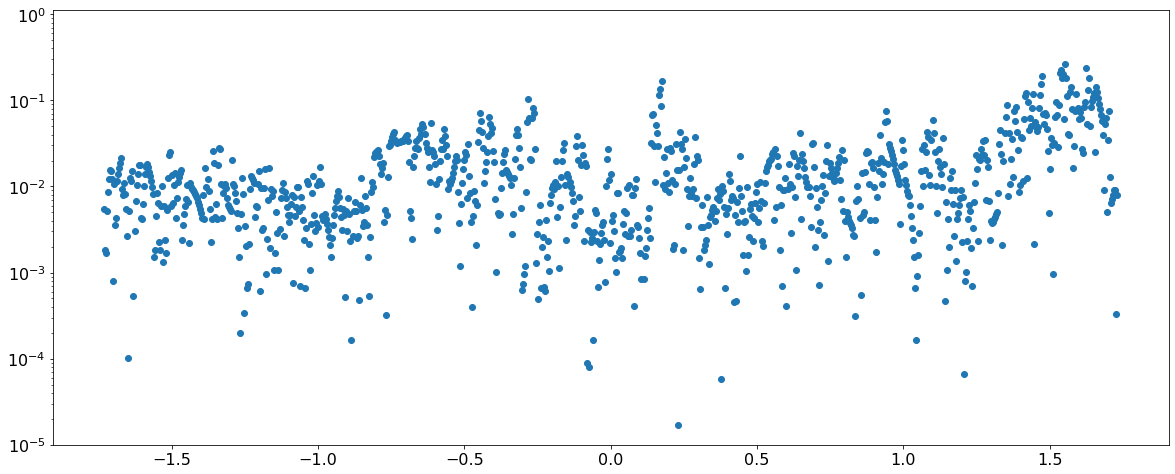

In [54]:
plt.figure(figsize=(20,8))
plt.scatter(X, np.abs(y-yhat))
plt.yscale('log')
plt.ylim(1e-5)